In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

from skimage.io import imread
from sklearn.utils import shuffle
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.applications import MobileNetV2
from keras import layers, Model

# "No mezclar churras con merinas"

##  1 The problem
This problem requires creating a binary image classification model, training it with pictures of sheep of both churra and merina breeds to later be able to sort new incoming images.

In the data directory we have the subdirectories train and test, each of them divided in two more, separating churra and merina images.

In [3]:
root_path = "./data/"
train_path = root_path + "train"
test_path = root_path + "test"

## 2 The data

### 2.1 Load

We define a function that:
- iterates in the directories
- reads the images
- transforms their three RGB channels to arrays
- obtains the label from the directory name

In [4]:
def read_data(directorio, reshape_dim=(32,32)):
    X = [] 
    y = []
    for folder in os.listdir(directorio):
        if os.path.isdir(os.path.join(directorio, folder)):
            for file in os.listdir(os.path.join(directorio, folder)):
                image_path = os.path.join(directorio, folder, file)
                image = cv2.imread(image_path)
                if image is not None:  # Verify if the image was correctly read
                    image = cv2.resize(image, reshape_dim)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert from BGR  RGB

                    X.append(image)
                    y.append(folder)
                else:
                    print(f"Warning: image was not correctly read: {image_path}")
    return np.array(X), np.array(y)


In [5]:
X_test, y_test = read_data(test_path, reshape_dim=(128,128))
X_train, y_train = read_data(train_path, reshape_dim=(128,128))

With all that we get three-dimensional X arrays

In [6]:
X_train.shape, X_test.shape

((291, 128, 128, 3), (80, 128, 128, 3))

### 2.2 Visualization

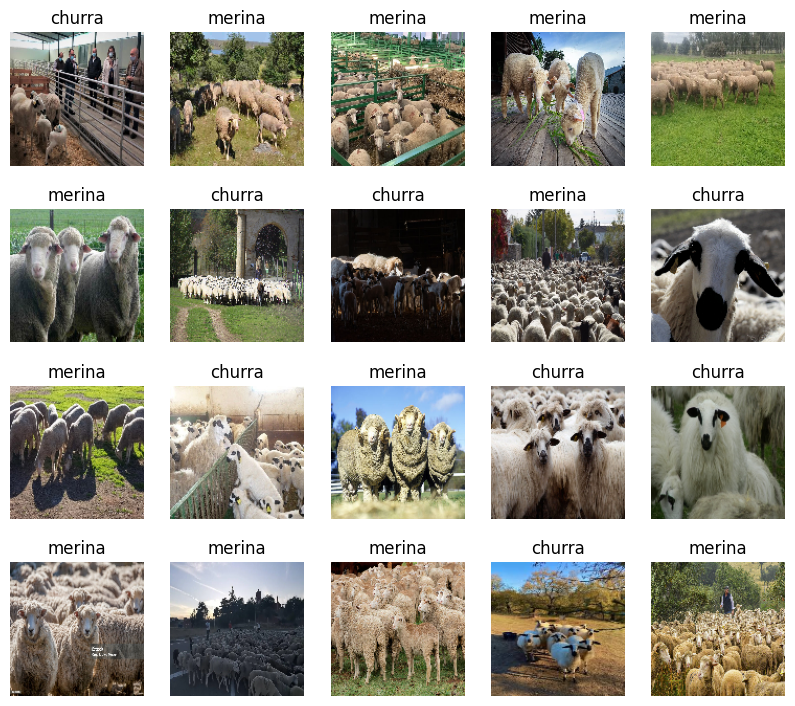

In [7]:
def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])
            
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

### 2.3 MiniEDA

Data is almost perfectly balanced

In [8]:
pd.Series(y_train).value_counts(True)

churra    0.501718
merina    0.498282
Name: proportion, dtype: float64

Scaling the data to get them in a range from 0 to 1, even though data is already in the same scale, will help activation functions.

In [9]:
X_train = X_train/255
X_test = X_test/255

Since the data is in order, we are shuffling them

In [10]:
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

Convolutional networks require integer labels to train, therefore we will transform them initializing two dictionaries to map the labels.

In [11]:
# to train
mapa = {"churra":0,
        "merina":1}

# and for seeing the results
inverse_mapping = {0:"churra",
                   1:"merina"}

In [12]:
y_train_num = np.array(pd.Series(y_train).map(mapa))
y_test_num = np.array(pd.Series(y_test).map(mapa))

## 3 The model

### 3.1 Ensambling
For this problem we will be using Transfer Learning
- a customized head:
    - flattening layer
    - dense layer with the flattened resolution number of units and relu activation function
    - dropout layer with a .5 rate
    - output layer with two units (binary problem) and a softmax activation function

- with pretrained MobileNetV2 with the imagenet weights

In [13]:
output = 128*128
output

16384

Creating a model through a function allows the model to be created from scratch each time it's executed, as when a deep learning model has already been trained, the weights are retained.

In [14]:
base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(128,128,3))

for layer in base_model.layers:
    layer.trainable = False

def prepare_model(base_model=base_model):
    x = layers.Flatten()(base_model.output)

    x = layers.Dense(output, activation="relu")(x)
    x = layers.Dropout(rate=.50)(x)

    x = layers.Dense(2, activation="softmax")(x)

    model = Model(base_model.input,x)

    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
    
    return model

model = prepare_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 337,851,458 (1.26 GB)

 Trainable params: 335,593,474 (1.25 GB)

 Non-trainable params: 2,257,984 (8.61 MB)

### 3.2 Training

Initializing a callback to stop the fitting when no significant improvements are happening anymore will help us keep the best weights.

In [15]:
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

We initialize the model using the function previously defined and train it.

In [16]:
model = prepare_model()
history = model.fit(X_train, y_train_num,
                    batch_size = 32,
                    validation_split = .2,
                    epochs = 100,
                    callbacks = [early_stopping])

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - acc: 0.6221 - loss: 32.4738 - val_acc: 0.7627 - val_loss: 14.6047
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - acc: 0.8301 - loss: 6.6598 - val_acc: 0.6610 - val_loss: 22.1364
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - acc: 0.8600 - loss: 5.3900 - val_acc: 0.9322 - val_loss: 2.5019
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - acc: 0.9222 - loss: 2.9052 - val_acc: 0.8644 - val_loss: 3.9016
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - acc: 0.9682 - loss: 0.8349 - val_acc: 0.9153 - val_loss: 3.1359
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - acc: 1.0000 - loss: 0.0000e+00 - val_acc: 0.8644 - val_loss: 8.3497
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - acc: 0.9833 - loss: 0.5888 - val_acc: 0.9492 - val_loss: 2.4510
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - acc: 1.0000 - loss: 0.0000e+00 - val_acc: 0.9322 - val_loss: 1.7092
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - acc: 0.9980 - loss

### 3.3 Evaluation

Seems that the model is overfitting to the train data (memorizing it instead of learning generalizable patterns), but despite that evaluation against the test data is very good.

In [17]:
model.evaluate(X_test, y_test_num)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 502ms/step - acc: 0.9297 - loss: 5.4099


[5.339139461517334, 0.9375]

In [18]:
y_pred = [inverse_mapping[np.argmax(prediccion)] for prediccion in model.predict(X_test)]
print(classification_report(y_test, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step  
              precision    recall  f1-score   support

      churra       0.97      0.90      0.94        40
      merina       0.91      0.97      0.94        40

    accuracy                           0.94        80
   macro avg       0.94      0.94      0.94        80
weighted avg       0.94      0.94      0.94        80



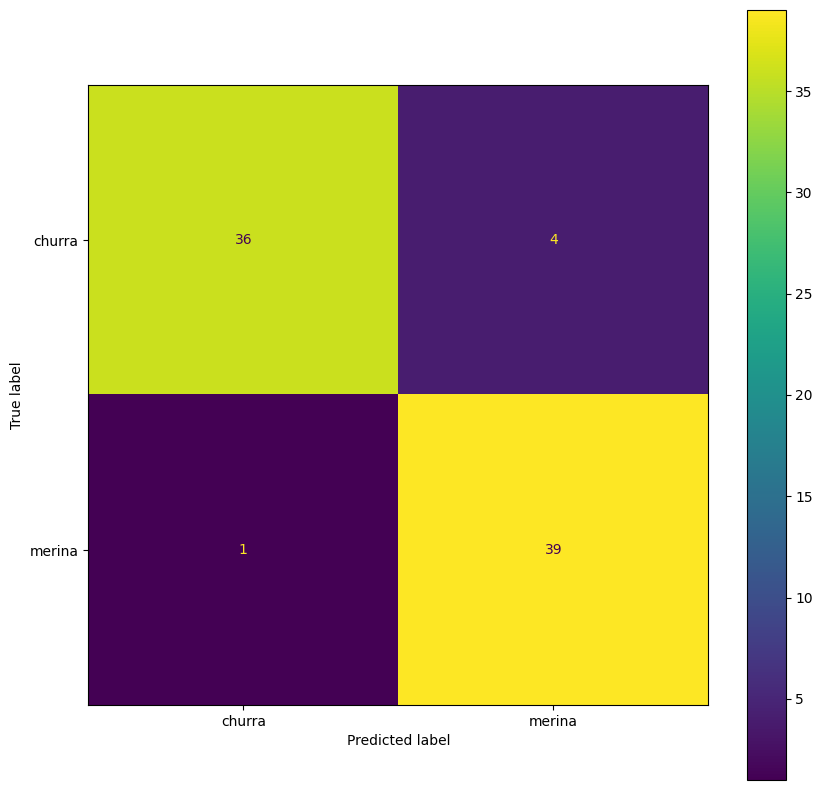

In [19]:
fig,axs = plt.subplots(1,1,figsize = (10,10))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax = axs)

### 3.4 Error validation

The model has only mistaken 5 sheep, let's take a look:

In [24]:
df_predicciones = pd.DataFrame({"true":y_test, "pred":y_pred})

errores = df_predicciones[df_predicciones["true"] != df_predicciones["pred"]]
indices = errores.index
indices

Index([18, 20, 27, 63, 66], dtype='int64')

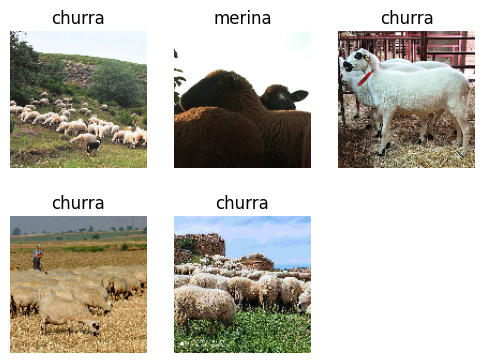

In [25]:
show_images_batch(X_test[indices], names=y_test[indices], n_cols=3)

## 4 Save model

In [26]:
from tensorflow.keras.models import save_model

save_model(model, 'model_churrasymerinas.keras')